# Graph Theoretic Methods in Multiagent Networks
## Chapter 3: The Agreement Protocol: Part I–The Static Case
Mehran Mesbahi and Magnus Egerstedt

#### Summary:

Agreement protocols are essential for multiagent coordination, aiming for agents to agree on a joint state value. This chapter explores the dynamics of agreement protocols over both undirected and directed static networks, emphasizing the relationship between convergence properties and network structure.
The agreement protocol facilitates this consensus through information sharing networks.

#### Key points:
1. Agreement protocols are crucial for solving multiagent coordination problems.
2. Convergence properties of these protocols are influenced by network structure.
3. The protocol involves dynamic units interconnected via information-exchange links, with each unit's state change influenced by its neighbors.
4. Understanding the agreement protocol offers insights into network topology's role in dynamic processes.

#### Import libraries

##### To export later notebook to PDF

In [1]:
from IPython.display import display, Latex

##### We do need this ones

In [2]:
import numpy as np
import networkx as nx
from scipy import linalg
import matplotlib.pyplot as plt
np.random.seed(42)

# 3.1 Agreement or Consensus protocol

A network may be considered as a set of nodes or agents that collaborate to achieve what **each cannot achieve alone**.

### Notation:

$x_i (t)$: time-varying state vector from node i of a graph

$(G,x)$: Graph with node dynamics

$N$: Nodes

$x = [x_i^T …. x_N^T]^T$ : Global state vector

Each node evolves according to some dynamics $\dot{x}_i = f_i(x_i, u_i)$

where $u_i$ is a control input and $f_i(.)$ is some flow function

> **Definition Consensus Problem**: Find a distributed control protocol that drives all states to the same values $x_i = x_j$ = $∀i,j$ . This value is known as a consensus value.
>

## Definitions

Given the following triangle graph:

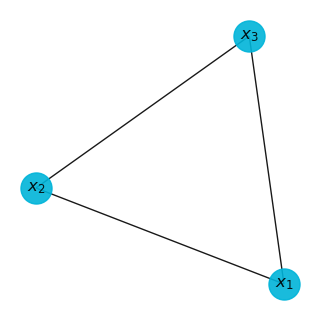

In [3]:
edge_list = [(1, 2), 
             (2, 3),
             (3, 1)]

n = 3 # Nodes
# Initial state
states_0 = np.array(10*np.random.rand(n)-5) 
nodes = [(i, {"states": [s, 0]}) for i, s in enumerate(states_0, 1)]

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)
fig = plt.figure(figsize=(3,3))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='#00b4d9', alpha=0.9,
    labels={node: f"$x_{node}$" for node in G.nodes()}
)

### Adjacency Matrix

The idea is that the cell $ m[i] [j] $ represents the edge weight of going from node $i$ to node $j$.

In [4]:
adj_matrix = nx.adjacency_matrix(G).toarray()
print(f"adj_matrix =\n {adj_matrix}")

adj_matrix =
 [[0 1 1]
 [1 0 1]
 [1 1 0]]


### Incidence matrix

The incidence matrix has one **row for each vertex** and one column for each edge.
The entry in row $i$ and column $j$ is:
- 1 if vertex ($v_i$) and edge ($e_j$) are related (i.e., incident).
- 0 if they are not related.

In [5]:
inc_matrix = nx.incidence_matrix(G).toarray()
print(f"inc_matrix =\n {inc_matrix}")

inc_matrix =
 [[1. 1. 0.]
 [1. 0. 1.]
 [0. 1. 1.]]


### Laplacian Matrix

It can be viewed as a matrix form of the negative discrete Laplace operator on a graph, approximating the negative continuous Laplacian obtained by the finite difference method.
Basically it's the second gradient of the graph: it measures how the values changes over the graph.

##### Definition:
Define the Jordan normal form of the graph Laplacian matrix by

$L= MJM^{−1}$

$J=\begin{bmatrix}
\lambda_1 &  & &\\
 & \lambda_2 & &\\
 & & ... & & \\
 & &  & \lambda_N
\end{bmatrix}$,
$M=\begin{bmatrix}
v_1 & v_2 & ... & v_N
\end{bmatrix}$

where the eigenvalues $λi$ and right eigenvectors $v_i$ satisfy:

$(\lambda I - L)v_i = 0$

with I being the identity matrix

The inverse of the transformation matrix M is given as

$M^{-1} = \begin{bmatrix} w_1^{T}\\w_2^{T}\\…\\w_N^{T} \end{bmatrix}$

where the left eigenvectors $w_i$ satisfy

$w_i^T(\lambda I - L) = 0$

and are normalized so that $w_i^Tv_i = 1$.

In [6]:
L=nx.laplacian_matrix(G).toarray()
print(f"laplacian_matrix =\n {L}")

laplacian_matrix =
 [[ 2 -1 -1]
 [-1  2 -1]
 [-1 -1  2]]


### Eigenvalues

Eigenvalues = [(-4.2379613713492356e-16+0j), (2.9999999999999996+0j), (2.9999999999999996+0j)]


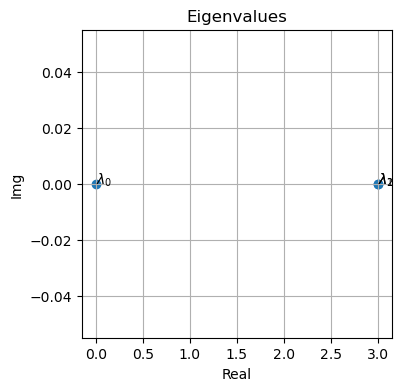

In [8]:
from utils import plot_complex

eigenvalues = sorted(linalg.eigvals(L))
print(f"Eigenvalues = {eigenvalues}")
fig2 = plot_complex(eigenvalues, "Eigenvalues")

### Left eigenvectors

In [9]:
w = linalg.eig(L, left=True, right=False)[1]
print("Left Eigenvectors (normalized):\n", w)

Left Eigenvectors (normalized):
 [[ 0.77611619 -0.57735027  0.        ]
 [-0.60767764 -0.57735027 -0.70710678]
 [-0.16843855 -0.57735027  0.70710678]]


### The Fiedler Eigenvalue

The second eigenvalue $λ_2$ (Fiedler Eigenvalue) of the graph Laplacian matrix $L$ is important in determining the speed of interaction of dynamic systems on graphs.

Graph topologies that have a **large** value of $λ_2$ are better for achieving convergence.

In [10]:
tau = 1/eigenvalues[1].real
Tss = 5*tau
display(Latex(f"$\lambda_2$={eigenvalues[1]:.2f}s"))
print(f"Tss={Tss:.2f}s")

<IPython.core.display.Latex object>

Tss=1.67s


## 3.1.1 Consensus with Single-Integrator Dynamics (Local voting protocol)

Considering the case where all nodes of the graph G have scalar single-integrator dynamics

$\dot{x}_i = u_i$

with $\dot{x}_i$, $u_i$ $\in \mathbb{R}$. This corresponds to endowing each node or agent with a memory.
 
The agreement protocol involves $n$ dynamic units, labeled $1$, $2$, . . . , $n$, interconnected via relative information exchange links. The rate of change of each unit’s state is assumed to be governed by the sum of its relative states with respect to a subset of other (neighboring) units.

Denoting the scalar state of unit $i$ as $x_i \in \mathbb{R}$, one then has

$\dot{x}_i(t) = \sum_{j\in N(i)}(x_j(t)-x_i(t))$, $i=1,...,n,$

where $N(i)$ is the set of units "adjacent to", or neighboring, unit $i$ in the network.

The control input of each node depends on the difference between its state and all its neighbors.
When the adopted notion of adjacency is symmetric, the overall system can be represented by

$\dot{x}_i(t)=u(t)=-L(\mathcal{G})x(t)$,

where the positive semidefinite matrix $L(\mathcal{G})$ is the Laplacian of the agents’ interaction network $\mathcal{G}$ and $x(t) = (x_1(t), . . . , x_n(t))^T \in \mathbb{R}^n$.

In [11]:
def local_voting_protocol(L, x):
    return -L @ x[:, 0]

> **Consensus for First-order Systems**: The local voting protocol guarantees consensus of the single-integrator dynamics if and only if the graph has a spanning tree. Then, all node states come to the same steady-state values $x_i = x_j = c, \forall i j$ .
>
The consensus value is given by

$c = \sum_{i=1}^N p_ix_i(0)$

> Let $\mathcal{G}$ be a connected graph. Then the (undirected) agreement protocol converges to the agreement set with a rate of convergence that is dictated by $\lambda_2(\mathcal{G})$.
>
By observing that for a connected graph $\lambda_i(\mathcal{G}) > 0$ for $i \geq 2$; as always, $\lambda_1(\mathcal{G}) = 0$. Thus

$x(t) \rightarrow (u^T_1 x_0)u_1 = \frac{1^T x_0}{n}1$ as $t \rightarrow \inf$

In [12]:
c = np.ones(n) @ states_0/n
print(f"consensus value = {c:.2f}")

consensus value = 1.86


### Simulation: Dynamic model

#### System definition
$\dot{x}_i = u_i$

In [13]:
def get_states_as_vector(G: nx.Graph):
    return np.matrix([G.nodes[node]["states"] for node in G.nodes])

def update_states(G_t: nx.Graph, u_t, dt):
    # Update current graph
    for node, u_i in zip(G_t.nodes, u_t.flat):
        G_t.nodes[node]["states"][0] += G_t.nodes[node]["states"][1]*dt
        G_t.nodes[node]["states"][1] = u_i
    return get_states_as_vector(G_t)

L = nx.laplacian_matrix(G)

##### Run simulation

In [15]:
T = 2*Tss
dt = 0.01
t_span = np.linspace(0, T, num=int(T/dt))
logs = np.zeros((len(t_span), n, 2))

for i, t in enumerate(t_span):
    x = get_states_as_vector(G)
    u = local_voting_protocol(L, x)
    logs[i][:] = update_states(G, u, dt)

#### Plot Results

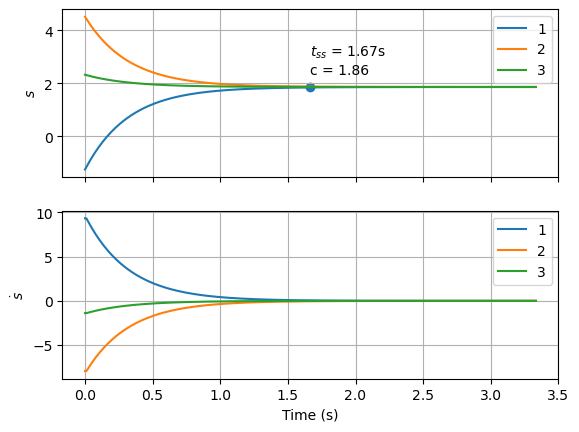

In [16]:
fig3, ax = plt.subplots(2, 1, sharex=True)
for v, node in enumerate(G.nodes):
    ax[0].plot(t_span, logs[:, v, 0], label = str(node))
    ax[1].plot(t_span, logs[:, v, 1], label = str(node))

## Annotate Cs, Tss
ax[0].annotate(f"$t_{{ss}}$ = {Tss:.2f}s\nc = {c:.2f}", (Tss, c+0.5))
ax[0].scatter(Tss, c)

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("$s$")
ax[1].set_ylabel("$\\dot{s}$")
plt.show()

## 3.1.2 Consensus Asymetric Adjacency Relation (Directed Graph)

Consider a group of three robots coordinating their respective speeds according to the following chain of command: the rate of change of the second robot's speed is dictated by its speed difference with respect to the first one; the rate of change of the third robot's speed is adjusted analogously with respect to the second one. Finally, the first robot adjusts its speed by the taking the average of its speed differences with respect to the second and third robots.

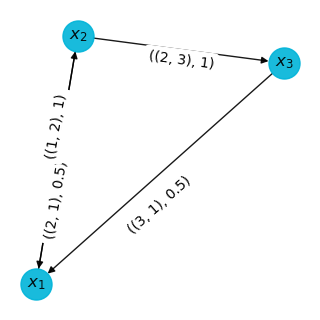

In [231]:
edge_list = [(1, 2, 1), 
             (2, 1, 1/2),
             (2, 3, 1),
             (3, 1, 1/2)]

n = 3 # Nodes
# Initial state
states_0 = np.array(10*np.random.rand(n)-5) 
nodes = [(i, {"states": [s, 0]}) for i, s in enumerate(states_0, 1)]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edge_list)
fig = plt.figure(figsize=(3,3))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='#00b4d9', alpha=0.9,
    labels={node: f"$x_{node}$" for node in G.nodes()}
)
labels = {(u, v): ((u, v), G.edges[u, v]['weight']) for u, v in G.edges}
_ = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, verticalalignment="top")
_ = nx.draw_networkx_edge_labels(G,pos,edge_labels={(1, 2):labels[(1, 2)]}, verticalalignment="bottom")

### Laplacian for Digraphs

The corresponding (in-degree) weighted Laplacian is now defined by:

$ L(\mathcal{D}) = \Delta(\mathcal{D}) - A(\mathcal{D}) $,

where
* \Delta(\mathcal{D}) is the diagonal matrix of in-degrees (number of edges pointing to each node).
* (A) is the adjacency matrix (weighted or unweighted).

For the diagonal degree matrix $\Delta(\mathcal{D})$ we set

$ [\Delta(\mathcal{D})]_{ii} = d_{in}(v_i) $ for all $i$,

where $d_{in}(v)$ is the weighted in-degree of vertex $v$, that is,

$d_{in}(v_i) = \sum_{j | (v_j, v_i) \in E(\mathcal{D})} w_{ij}$,

We note that: 

$ \Delta(\mathcal{D}) = Diag(A(\mathcal{D})1) $

In [232]:
in_degrees = dict(G.in_degree(weight='weight'))
D = np.diag(list(in_degrees.values())) 
A = nx.adjacency_matrix(G).toarray()
L_in = D - A  # Compute in-degree Laplacian
L = L_in.T
print(f"in-degree Laplacian =\n {L}")

in-degree Laplacian =
 [[ 1.  -0.5 -0.5]
 [-1.   1.   0. ]
 [ 0.  -1.   1. ]]


Eigenvalues = [(-3.1660569232725585e-17+0j), (1.5-0.5j), (1.5+0.5j)]


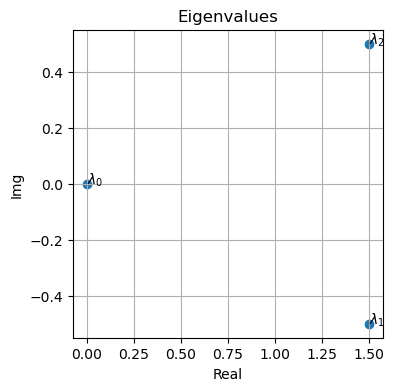

In [233]:
eigenvalues = sorted(linalg.eigvals(L))
print(f"Eigenvalues = {eigenvalues}")
fig2 = plot_complex(eigenvalues, "Eigenvalues")

### System Dynamics

Denoting the speed of robot i by si, the dynamics of the resulting system can be written as:
$\dot{s}_1(t) = \frac{1}{2}((s_3(t)-s_1(t))+(s_2(t)-s_1(t)))$
$\dot{s}_2(t) = s_1(t)-s_2(t)$
$\dot{s}_3(t) = s_2(t)-s_3(t)$

which assumes the form:

$\dot{s}(t) = \begin{bmatrix}
-1 & \frac{1}{2} & \frac{1}{2} \\
1 & -1 & 0 \\
0 & 1 & -1 
\end{bmatrix} s(t)$,

We note that the matrix corresponds to the negative of the in-degree Laplacian of the network, thus:
$\dot{s}(t) = -L(\mathcal{D})s(t)$,

where $\mathcal{D}$ is the underlying directed interconnection, that is, the weighted digraph of the network.

In [234]:
def local_voting_protocol(L, x):
    return -L @ x[:, 0]

In [235]:
def get_states_as_vector(G: nx.Graph):
    return np.matrix([G.nodes[node]["states"] for node in G.nodes])

def update_states(G_t: nx.Graph, u_t, dt):
    # Update current graph
    for node, u_i in zip(G_t.nodes, u_t.flat):
        G_t.nodes[node]["states"][0] += G_t.nodes[node]["states"][1]*dt
        G_t.nodes[node]["states"][1] = u_i # u_i = -L*s
    return get_states_as_vector(G_t)

#### Settling time

In [236]:
tau = 1/eigenvalues[1].real
Tss = 5*tau
display(Latex(f"$\lambda_2$={eigenvalues[1]:.2f}s"))
print(f"Tss={Tss:.2f}s")

<IPython.core.display.Latex object>

Tss=3.33s


#### Consensus Value

**3.14** : Let $L(\mathcal{D}) = PJ(Λ)P^{−1}$ be the Jordan decomposition of the (in-degree) Laplacian for the digraph $\mathcal{D}$. When $\mathcal{D}$ contains a rooted out-branching, the nonsingular matrix $P$ can be chosen such that

$ J(Λ) = \begin{bmatrix}
 0 & 0 & ... & 0 \\
 0 & J(\lambda_2) & ... & 0 \\
 0 & 0 & ... & 0 \\
 0 & 0 & ... & J(\lambda_n) \\
\end{bmatrix}$

where the $\lambda_i$s ($i$ = 2, . . . , $n$) have positive real parts, and $J(\lambda_i)$ is the Jordan block associated with eigenvalue $\lambda_i$.

For a digraph \mathcal{D} containing a rooted out-branching, the state trajectory generated by (3.14), initialized from $x_0$, satisfies 

$\lim_{t\to\infty} x(t) = (p_1q_1^T)x_0$

where $p_1$ and $q_1$, are, respectively, the right and left eigenvectors associated with the zero eigenvalue of $L(\mathcal{D})$, normalized such that $p^T_1 q_1 = 1$. As a result, one has $x(t) \to \mathcal{A}$ for all initial conditions if and only if $\mathcal{D}$ contains a rooted out-branching.

Recall that the constant of motion for the agreement protocol over an undirected
graph is the sum of the node states at any given time

In [237]:
idx = np.argmin(linalg.eigvals(L)) ## Zero eigenvalue
p = linalg.eig(L, left=False, right=True)[1][: , idx]
q = linalg.eig(L, left=True, right=False)[1][: , idx]

inner_product = p.T@q
p_norm = p / np.sqrt(inner_product)
q_norm = q / np.sqrt(inner_product)

display(Latex(f"$p_1^Tq_1 = {p_norm.T @ q_norm}$"))

<IPython.core.display.Latex object>

In [261]:
c = ((p_norm*q_norm.T) @ states_0).real
print(f"consensus value = {c:.2f}")

consensus value = 0.59


##### Run simulation

In [240]:
T = 2*Tss
dt = 0.01
t_span = np.linspace(0, T, num=int(T/dt))
logs = np.zeros((len(t_span), n, 2))

for i, t in enumerate(t_span):
    x = get_states_as_vector(G)
    u = local_voting_protocol(L, x)
    logs[i][:] = update_states(G, u, dt)

#### Plot Results

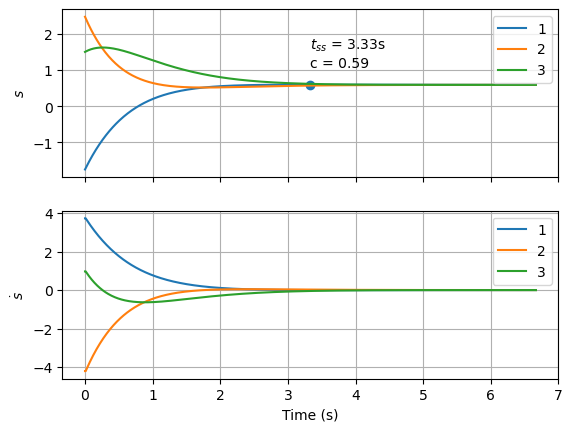

In [263]:
fig3, ax = plt.subplots(2, 1, sharex=True)
for v, node in enumerate(G.nodes):
    ax[0].plot(t_span, logs[:, v, 0], label = str(node))
    ax[1].plot(t_span, logs[:, v, 1], label = str(node))

## Annotate Cs, Tss
ax[0].annotate(f"$t_{{ss}}$ = {Tss:.2f}s\nc = {c:.2f}", (Tss, c+0.5))
ax[0].scatter(Tss, c)

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("$s$")
ax[1].set_ylabel("$\\dot{s}$")
plt.show()